In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import csv
import time

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(1234)

In [3]:
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [4]:
dataset = dataset.values

In [5]:
dataset = dataset.astype('float32')

In [6]:
# Normalize the dataset
scaler = MinMaxScaler(copy=False) #Feature range 0,1
scaler.fit_transform(dataset)

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753],
       [ 0.        ],
       [ 0.02702703],
       [ 0.02123553],
       [ 0.04247104],
       [ 0.07142857],
       [ 0.05984557],
       [ 0.04054055],
       [ 0.08687258],
       [ 0.12741312],
       [ 0.12741312],
       [ 0.10424709],
       [ 0.05598456],
       [ 0.01930502],
       [ 0.06949806],
       [ 0.07915059],
       [ 0.08880308],
       [ 0.14285713],
       [ 0.11389962],
       [ 0.13127413],
       [ 0.14285713],
       [ 0.18339768],
       [ 0.18339768],
       [ 0.15444016],
       [ 0.11196911],
       [ 0.08108109],
       [ 0.1196911 ],
       [ 0.12934363],
       [ 0.14671814],
       [ 0.17181468],
       [ 0.14864865],
       [ 0.15250966],
       [ 0.22007722],
       [ 0.24324325],
       [ 0.26640925],
       [ 0.2027027 ],
       [ 0

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(96, 48)


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [9]:
look_back = 1
train_x, train_y = create_dataset(train,look_back)
test_x, test_y = create_dataset(test,look_back)

NameError: global name 'numpy' is not defined

In [10]:
train_x.shape, test_x.shape

NameError: name 'train_x' is not defined

In [11]:
train_y.shape, test_y.shape

NameError: name 'train_y' is not defined

### Power Consumption Example

In [12]:
def data_power_consumption(path_to_dataset='household_power_consumption.txt', sequence_length=50, ratio=1.0):

    max_values = ratio * 2049280

    with open(path_to_dataset) as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[2]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values / 2049280.0 >= ratio:
                break
        return power

In [13]:
power = data_power_consumption()

In [14]:
len(power) # Number of observations

2049280

In [15]:
sequence_length = 50
result = []
for index in range(len(power) - sequence_length):
    result.append(power[index: index + sequence_length])
result = np.array(result)  # shape (2049230, 50)

In [16]:
result.shape

(2049230, 50)

In [17]:
# Zero mean data
result_mean = result.mean()
result -= result_mean
print "Shift : ", result_mean
print "Data  : ", result.shape

Shift :  1.09157810417
Data  :  (2049230, 50)


In [18]:
# result array shape (2049230, 50)
# Split the train and test
row = int(round(0.9 * result.shape[0]))
train = result[:row, :]
np.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = result[row:, :-1]
y_test = result[row:, -1]

In [19]:
# Reshape data to fit into the NN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [20]:
def build_model():
    model = Sequential()
    layers = [1, 50, 100, 1]
    model.add(LSTM(
            input_dim=layers[0],
            output_dim=layers[1],
            return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
            layers[2],
            return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(
            output_dim=layers[3]))
    model.add(Activation("linear"))
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model

In [21]:
model = build_model()

Compilation Time :  0.0257279872894


In [23]:
global_start_time = time.time()
epochs = 1
try:
    model.fit(
        X_train, y_train,
        batch_size=512, nb_epoch=epochs, validation_split=0.05)
    predicted = model.predict(X_test)
    predicted = np.reshape(predicted, (predicted.size,))
except KeyboardInterrupt:
    print 'Training duration (s) : ', time.time() - global_start_time

Train on 1752091 samples, validate on 92216 samples
Epoch 1/1
1752091/1752091 [==============================] - 2986s - loss: 0.0807 - val_loss: 0.0652

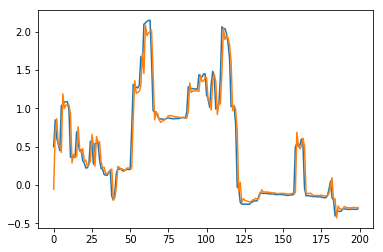

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test[:200])
plt.plot(predicted[:200])
plt.show()

In [25]:
# result array shape (2049230, 50)
# Split the train and test
row = int(round(0.9 * result.shape[0]))
train = result[:row, :]
np.random.shuffle(train)
X_train_1 = train[:, 48].reshape(-1,1)
y_train_1 = train[:, 49].reshape(-1,1)
X_test_1 = result[row:, 48].reshape(-1,1)
y_test_1 = result[row:, 49].reshape(-1,1)

In [26]:
X_train_1.shape

(1844307, 1)

In [27]:
# Reshape data to fit into the NN
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], 1))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], 1))

In [28]:
X_train_1.shape

(1844307, 1, 1)

In [29]:
model_1 = build_model()

Compilation Time :  0.0264761447906


In [30]:
global_start_time = time.time()
epochs = 1
try:
    model_1.fit(
        X_train_1, y_train_1,
        batch_size=512, nb_epoch=epochs, validation_split=0.05)
    predicted_1 = model_1.predict(X_test_1)
    predicted_1 = np.reshape(predicted_1, (predicted_1.size,))
except KeyboardInterrupt:
    print 'Training duration (s) : ', time.time() - global_start_time

Train on 1752091 samples, validate on 92216 samples
Epoch 1/1
1752091/1752091 [==============================] - 87s - loss: 0.0890 - val_loss: 0.0717

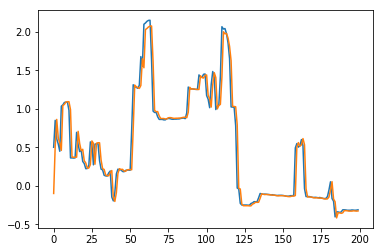

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test[:200])
#plt.plot(predicted[:200])
plt.plot(predicted_1[:200])
plt.show()

## 